a regression forecasting task
1. modelling with low rmse 
2. explanability: importance of different attributes
3. evaluation and comparison of different regression techniques 
4. error analysis (which data points do we fail at? are there some clustering involved)
5. limitations and potential extensions, etc.

In [1]:
import pandas as pd
import numpy as np
import os, re
import warnings
warnings.filterwarnings('ignore')
from dateutil.relativedelta import relativedelta

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
from collections import Counter
from datetime import datetime
dates_dict = {
    'B_birthday': '%Y-%m-%d', 
    'B_dtopentime': '%Y-%m-%d %H:%M:%S'
}

current_folder = os.path.abspath(os.curdir)
root_folder = os.path.dirname(current_folder) 
data_folder = os.path.join(root_folder,'data')
%matplotlib inline

In [2]:
train_df = pd.read_csv(os.path.join(data_folder,'train.csv'))
test_df = pd.read_csv(os.path.join(data_folder,'test.csv'))
train_df.head()

month         town flat_type block            street_name storey_range  \
0  2001-08    pasir ris    4 room   440      pasir ris drive 4     01 to 03   
1  2014-10      punggol    5-room  196B          punggol field     10 to 12   
2  2020-09     sengkang    5 room  404A          fernvale lane     01 to 03   
3  2000-10     clementi    3 room   375      clementi avenue 4     07 to 09   
4  2013-01  bukit batok    3-room   163  bukit batok street 11     07 to 09   

   floor_area_sqm         flat_model   eco_category  lease_commence_date  \
0           118.0            model a  uncategorized                 1989   
1           110.0           improved  uncategorized                 2003   
2           112.0  premium apartment  uncategorized                 2004   
3            67.0     new generation  uncategorized                 1980   
4            73.0            model a  uncategorized                 1985   

   latitude   longitude  elevation           subzone planning_area  \
0  1.369008  103.958697        0.0   pasir ris drive     pasir ris   
1  1.399007  103.906991        0.0     punggol field       punggol   
2  1.388348  103.873815        0.0          fernvale      sengkang   
3  1.318493  103.766702        0.0    clementi north      clementi   
4  1.348149  103.742658        0.0  bukit batok west   bukit batok   

              region  resale_price  
0        east region      209700.0  
1  north-east region      402300.0  
2  north-east region      351000.0  
3        west region      151200.0  
4        west region      318600.0

In [3]:
print(train_df.columns)

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'eco_category', 'lease_commence_date',
       'latitude', 'longitude', 'elevation', 'subzone', 'planning_area',
       'region', 'resale_price'],
      dtype='object')


In [4]:
train_df.isnull().sum()

month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
eco_category           0
lease_commence_date    0
latitude               0
longitude              0
elevation              0
subzone                0
planning_area          0
region                 0
resale_price           0
dtype: int64

In [5]:
train_df.describe(include = 'all')

month       town flat_type   block       street_name storey_range  \
count    431732     431732    431732  431732            431732       431732   
unique      251         26        12    2472              1103           25   
top     2010-07  woodlands    4 room       1  yishun ring road     04 to 06   
freq       2926      39261    135679    1670              4392       107275   
mean        NaN        NaN       NaN     NaN               NaN          NaN   
std         NaN        NaN       NaN     NaN               NaN          NaN   
min         NaN        NaN       NaN     NaN               NaN          NaN   
25%         NaN        NaN       NaN     NaN               NaN          NaN   
50%         NaN        NaN       NaN     NaN               NaN          NaN   
75%         NaN        NaN       NaN     NaN               NaN          NaN   
max         NaN        NaN       NaN     NaN               NaN          NaN   

        floor_area_sqm flat_model   eco_category  lease_commence_date  \
count    431732.000000     431732         431732        431732.000000   
unique             NaN         20              1                  NaN   
top                NaN    model a  uncategorized                  NaN   
freq               NaN     127539         431732                  NaN   
mean         96.970064        NaN            NaN          1989.421004   
std          25.190664        NaN            NaN            10.254055   
min          31.000000        NaN            NaN          1966.000000   
25%          74.000000        NaN            NaN          1983.000000   
50%          99.000000        NaN            NaN          1988.000000   
75%         114.000000        NaN            NaN          1997.000000   
max         280.000000        NaN            NaN          2019.000000   

             latitude      longitude  elevation        subzone planning_area  \
count   431732.000000  431732.000000   431732.0         431732        431732   
unique            NaN            NaN        NaN            155            32   
top               NaN            NaN        NaN  tampines east     woodlands   
freq              NaN            NaN        NaN          19557         39261   
mean         1.364939     103.836492        0.0            NaN           NaN   
std          0.042829       0.073527        0.0            NaN           NaN   
min          1.270380     103.685228        0.0            NaN           NaN   
25%          1.336154     103.772439        0.0            NaN           NaN   
50%          1.358958     103.840160        0.0            NaN           NaN   
75%          1.389004     103.895779        0.0            NaN           NaN   
max          1.457071     103.987805        0.0            NaN           NaN   

             region  resale_price  
count        431732  4.317320e+05  
unique            5           NaN  
top     west region           NaN  
freq         109392           NaN  
mean            NaN  3.018196e+05  
std             NaN  1.298623e+05  
min             NaN  2.970000e+04  
25%             NaN  2.052000e+05  
50%             NaN  2.839500e+05  
75%             NaN  3.735000e+05  
max             NaN  1.123200e+06

In [6]:
def dummify(df, i, drop_orig=True):
    dummies = pd.get_dummies(df[i], columns=i, prefix=i, drop_first=True)
    if drop_orig:
        return dummies
    else:
        dummies = pd.concat([df[i], dummies], axis=1)
        dummies.columns = [i]+list(dummies.columns)[1:]
        return dummies

dummify(train_df, 'town', drop_orig=False).head()

town  town_bedok  town_bishan  town_bukit batok  town_bukit merah  \
0    pasir ris           0            0                 0                 0   
1      punggol           0            0                 0                 0   
2     sengkang           0            0                 0                 0   
3     clementi           0            0                 0                 0   
4  bukit batok           0            0                 1                 0   

   town_bukit panjang  town_bukit timah  town_central area  \
0                   0                 0                  0   
1                   0                 0                  0   
2                   0                 0                  0   
3                   0                 0                  0   
4                   0                 0                  0   

   town_choa chu kang  town_clementi  ...  town_pasir ris  town_punggol  \
0                   0              0  ...               1             0   
1                   0              0  ...               0             1   
2                   0              0  ...               0             0   
3                   0              1  ...               0             0   
4                   0              0  ...               0             0   

   town_queenstown  town_sembawang  town_sengkang  town_serangoon  \
0                0               0              0               0   
1                0               0              0               0   
2                0               0              1               0   
3                0               0              0               0   
4                0               0              0               0   

   town_tampines  town_toa payoh  town_woodlands  town_yishun  
0              0               0               0            0  
1              0               0               0            0  
2              0               0               0            0  
3              0               0               0            0  
4              0               0               0            0  

[5 rows x 26 columns]

Plot for "month"


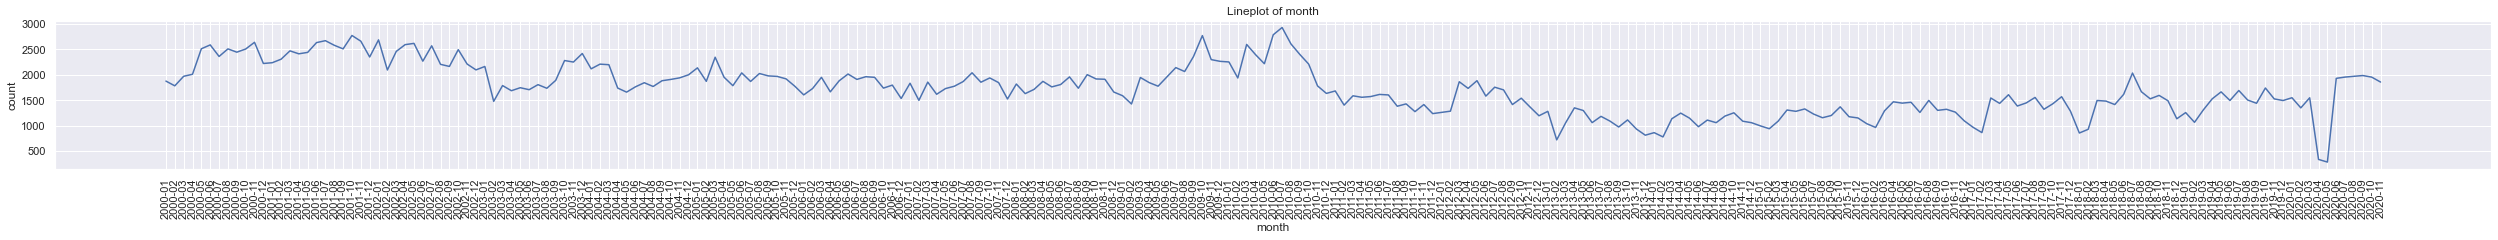

Plot for "town"


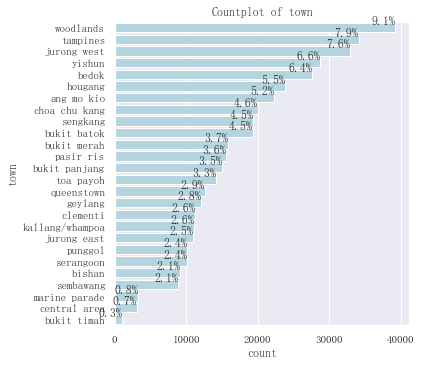

Plot for "flat_type"


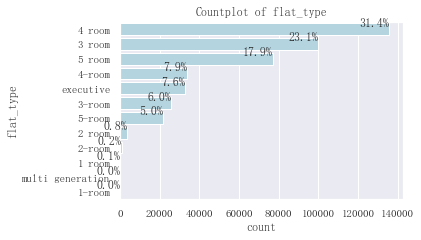

Plot for "block"


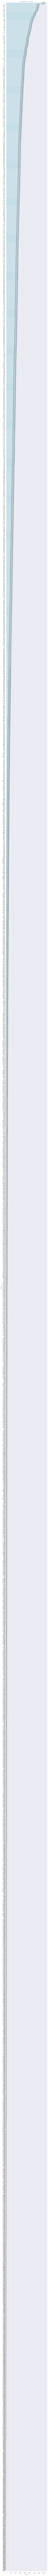

Plot for "street_name"


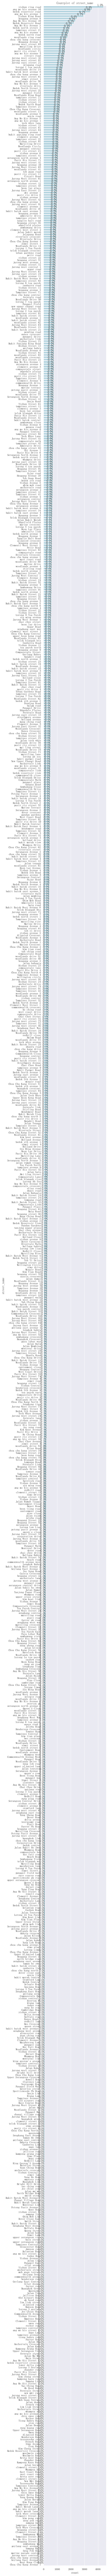

Plot for "storey_range"


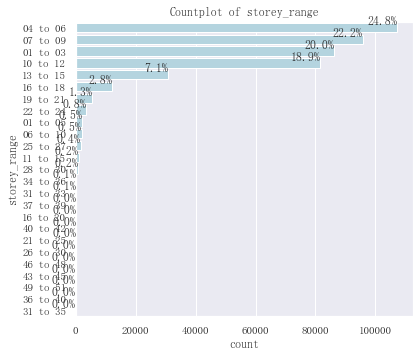

Plot for "floor_area_sqm"


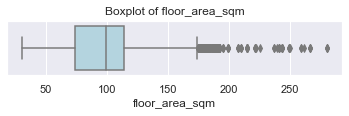

Plot for "flat_model"


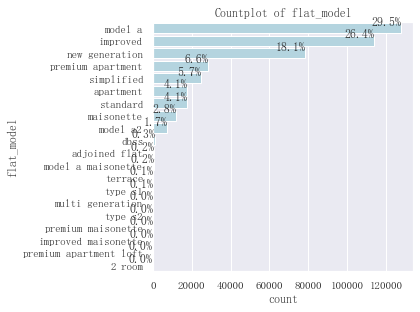

Plot for "eco_category"


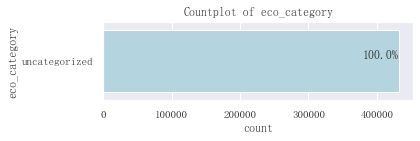

Plot for "lease_commence_date"


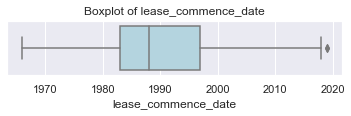

Plot for "latitude"


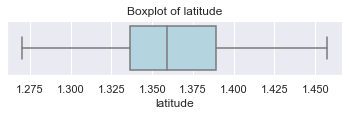

Plot for "longitude"


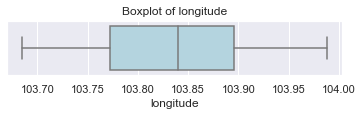

Plot for "elevation"


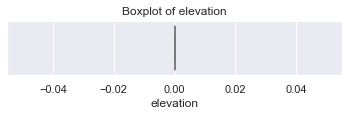

Plot for "subzone"


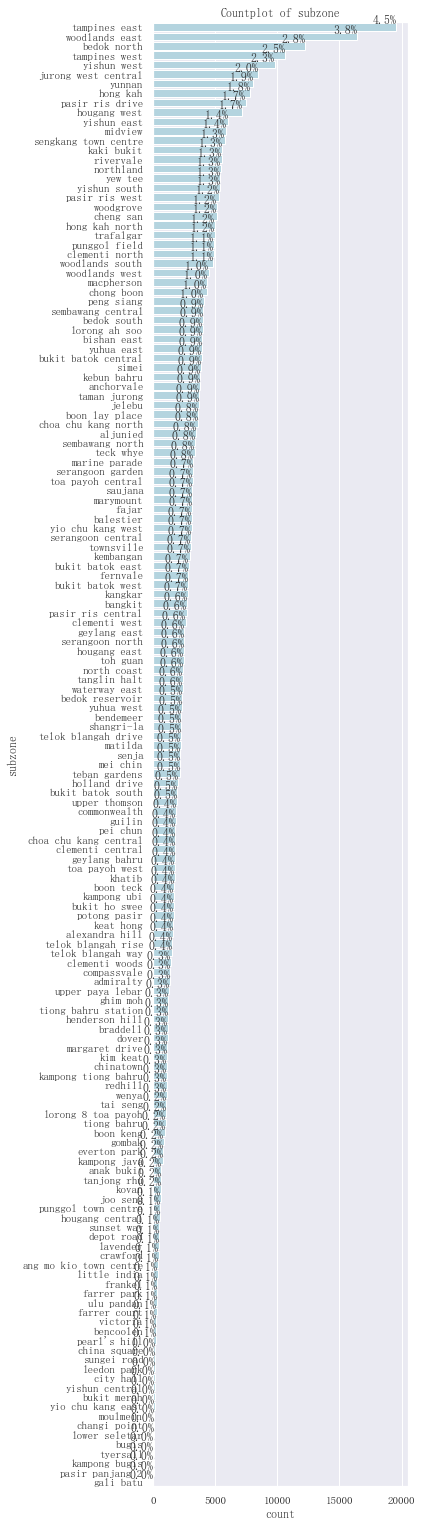

Plot for "planning_area"


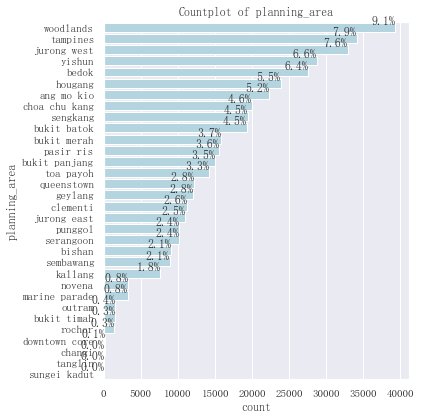

Plot for "region"


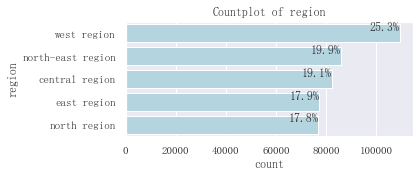

Plot for "resale_price"


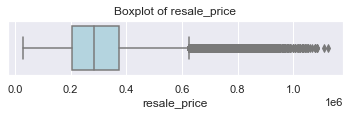

----- auto eda summary -----
identified bools: []
identified numerics: ['floor_area_sqm', 'lease_commence_date', 'latitude', 'longitude', 'elevation', 'resale_price']
identified strings: ['town', 'flat_type', 'block', 'street_name', 'storey_range', 'flat_model', 'eco_category', 'subzone', 'planning_area', 'region']
cols to fix: ['month']


In [7]:
dummy_list = []
bools = []
numerics = []
strings = []

def plot_lineplot(df, i, rotation=None, width=6, height=3.5, save=False, convert=False):
    if convert:
        df[i] = df[i].applymap(lambda x: re.sub('[^0-9]', '', x))
    x = df[i].dropna()
    nums = dict(Counter(x))
    nums_df = pd.DataFrame({
        i: list(nums.keys()),
        'count': list(nums.values())
    })
    sns.set(rc={'figure.figsize':(width, height)})
    ax = sns.lineplot(data=nums_df, x=i, y='count')
    ax.set_title(f'Lineplot of {i}')
    if rotation is not None:
        plt.xticks(rotation=rotation)
    plt.tight_layout()
    if save: plt.savefig(f'figs/eda_{i}_lineplot', bbox_inches = "tight")
    plt.show()
    
def plot_numeric(df, i, save=False):
    x = df[i]
    sns.set(rc={'figure.figsize':(6,1)})
    ax = sns.boxplot(x, color='lightblue')
    ax.set_title(f'Boxplot of {i}')
    plt.tight_layout()
    if save: plt.savefig(f'figs/eda_{i}_boxplot', bbox_inches = "tight")
    plt.show()
    
def plot_categorical(df, i, top_k=None, save=False):
    x = df[i]
    total = float(len(x))
    if top_k is None:
        n_cates = len(set(x))
    else:
        n_cates=top_k
    sns.set(rc={'figure.figsize':(6, n_cates/8+2)})
    sns.set(font="SimSun")
    ax = sns.countplot(y=x, color="lightblue", dodge=False, order = x.value_counts().iloc[:n_cates].index)
    for p in ax.patches:
        percentage = f'{100 * p.get_width() / total:.1f}%\n'
        x = p.get_width()
        y = p.get_y() + p.get_height() / 2
        ax.annotate(percentage, (x, y), ha='right', va='center')
    ax.set_title(f'Countplot of {i}')
    plt.tight_layout()
    if save: plt.savefig(f'figs/eda_{i}_countplot', bbox_inches = "tight")
    plt.show()
        
def plot_dates(df, i, save=False):
    x = df[i].dropna().apply(lambda d: datetime.strptime(d, dates_dict[i]))
    dates = dict(Counter(x))
    dates_df = pd.DataFrame({
        'date': list(dates.keys()),
        'count': list(dates.values())
    })
    sns.set(rc={'figure.figsize':(6,3.5)})
    ax = sns.lineplot(data=dates_df, x='date', y='count')
    ax.set_title(f'Lineplot of {i}')
    plt.tight_layout()
    if save: plt.savefig(f'figs/eda_{i}_lineplot', bbox_inches = "tight")
    plt.show()
    
def plot_all(df, top_k=None, save=False, num_string_pattern = '\d{4}\-\d{2}'):
    for i in df.columns:
        _df = df.dropna(subset=[i])
        if len(df)!=len(_df):
            print(f'Plot for "{i}" (Missing {len(df)-len(_df)} items...)')
        else:
            print(f'Plot for "{i}"')
        if is_numeric_dtype(df[i]):
            if len(set(_df))==2:
                bools.append(i, save=save)
                plot_categorical(_df, i, top_k=top_k, save=save)
            else:
                numerics.append(i)
                plot_numeric(_df, i, save=save)
                if i in dummy_list:
                    plot_categorical(_df, i, top_k=top_k, save=save)
        else:
            if i in dates_dict.keys():
                plot_dates(_df, i, save=save)
            elif all([bool(re.match(num_string_pattern, s)) for s in _df[i]]):
                # this matches Year-Month format of YYYY-MM (can custom pattern, or by |)
                plot_lineplot(_df, i, rotation=90, height=3.5, width=len(df[i].unique())/7.2, save=save)
            else:
                strings.append(i)
                plot_categorical(_df, i, save=save)
    
    print(f'----- auto eda summary -----')
    print(f'identified bools: {bools}')
    print(f'identified numerics: {numerics}')
    print(f'identified strings: {strings}')
    print(f'cols to fix: {list(train_df.columns.difference(bools+numerics+strings))}')
           
plot_all(train_df, save=False)

Plot for "month"


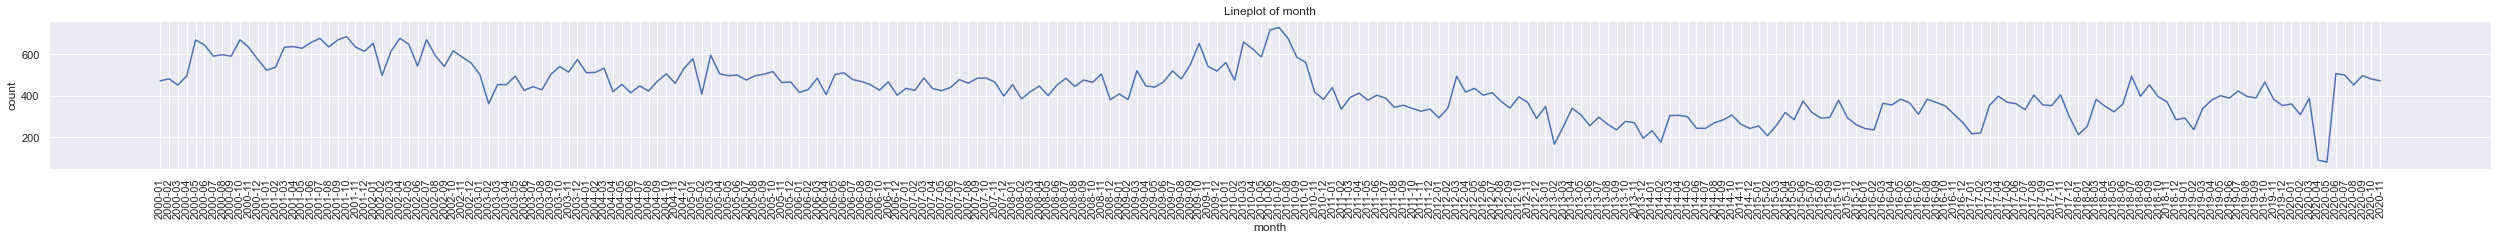

Plot for "town"


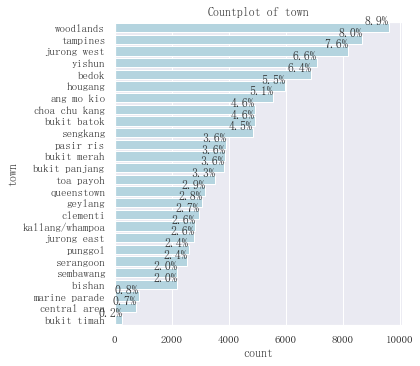

Plot for "flat_type"


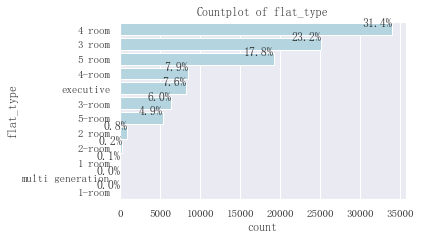

Plot for "block"


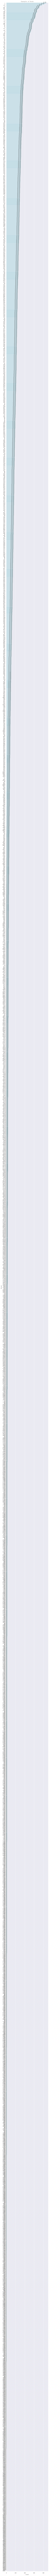

Plot for "street_name"


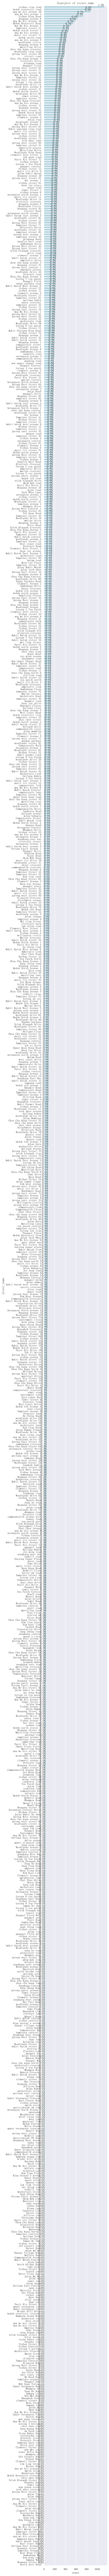

Plot for "storey_range"


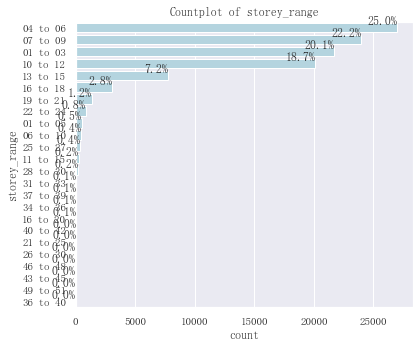

Plot for "floor_area_sqm"


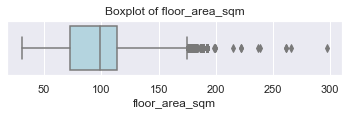

Plot for "flat_model"


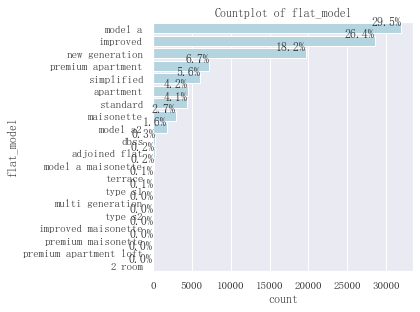

Plot for "eco_category"


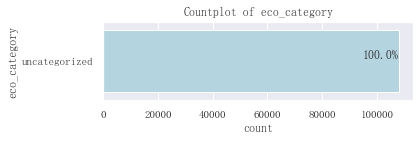

Plot for "lease_commence_date"


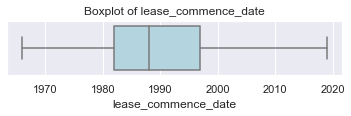

Plot for "latitude"


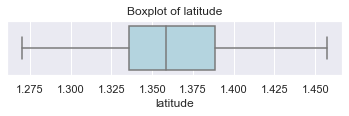

Plot for "longitude"


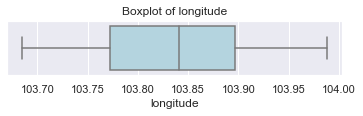

Plot for "elevation"


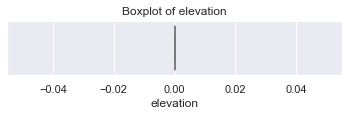

Plot for "subzone"


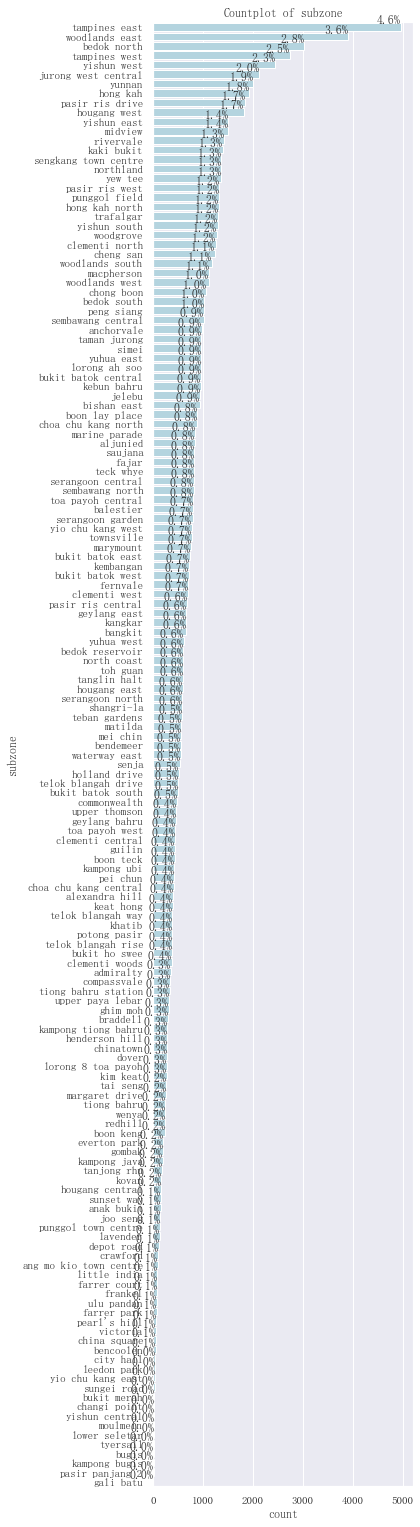

Plot for "planning_area"


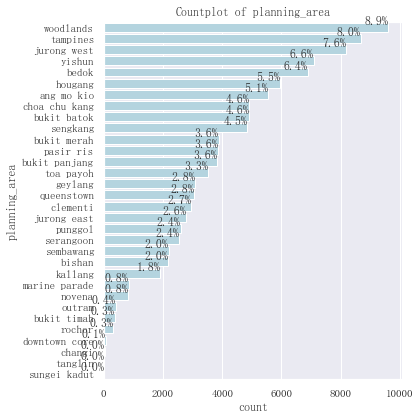

Plot for "region"


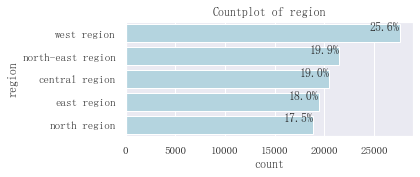

----- auto eda summary -----
identified bools: []
identified numerics: ['floor_area_sqm', 'lease_commence_date', 'latitude', 'longitude', 'elevation', 'resale_price', 'floor_area_sqm', 'lease_commence_date', 'latitude', 'longitude', 'elevation']
identified strings: ['town', 'flat_type', 'block', 'street_name', 'storey_range', 'flat_model', 'eco_category', 'subzone', 'planning_area', 'region', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'flat_model', 'eco_category', 'subzone', 'planning_area', 'region']
cols to fix: ['month']


In [12]:
plot_all(test_df, save=False)

##### observations

1. no missingness
2. typos in 'flat_type'
3. useless 1-level vars: 'eco_category', 'elevation'
4. check 'town' and 'planning_area' difference
5. cols with too many levels/imbalance levels (need to clean!): 'flat_model', 'sub_zone', 'storey_range', 'street_name', 'block'
6. train and test variable levels are thankfully similar! i.e. don't need to worry about not having information for unseen cases, probably quite easy to predict.


In [8]:
dtype_cate = ['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'flat_model', 
         'eco_category', 'subzone', 'planning_area', 'region', 'lease_commence_date']
dtype_num = ['floor_area_sqm', 'latitude', 'longitude','elevation', 'resale_price']

In [9]:
auxiliary_paths = {
    'commercial':'sg-commerical-centres.csv',
    'hawker': 'sg-gov-markets-hawker-centres.csv',
    'demographics': 'sg-population-demographics.csv',
    'pri_sch': 'sg-primary-schools.csv',
    'sec_sch': 'sg-secondary-schools.csv',
    'malls': 'sg-shopping-malls.csv',
    'train_stn': 'sg-train-stations.csv'
}

In [10]:
for aux in auxiliary_paths.keys():
    print(f'Opening auxiliary data bout "{aux}"...')
    aux_df = pd.read_csv(os.path.join(os.path.join(data_folder, 'auxiliary-data'), auxiliary_paths[aux]))
    print(aux_df.head(20))
    print('')

Opening auxiliary data bout "commercial"...
                            name  type       lat         lng
0      Central Business District    CR  1.286768  103.854529
1           Jurong Lake District    CR  1.334085  103.734513
2        Seletar Regional Centre    CR  1.409435  103.866820
3       Tampines Regional Centre    CR  1.353180  103.945188
4      Woodlands Regional Centre    CR  1.436748  103.786485
5         Airport Logistics Park  IEBP  1.375856  104.002617
6           Changi Aviation Park  IEBP  1.368803  104.001026
7           Changi Business Park  IEBP  1.335123  103.965127
8           Defu Industrial Park  IEPB  1.355457  103.895074
9    International Business Park  IEBP  1.327911  103.747405
10      Jurong Industrial Estate  IEBP  1.325451  103.695421
11    Jurong Innovation District  IEBP  1.353293  103.694896
12  Lorong Halus Industrial Park  IEBP  1.375386  103.902112
13      Loyang Industrial Estate  IEBP  1.383452  103.974425
14                     one-north  IEBP  1

##### observations

1. demographics file different from rest (no long/lat, might be harder to do matching)
2. personally, we know malls, train stations, distance to city, are key determinants of location price
3. not all malls are equal; not all schools are equal (See paper for Top 50 popular schools)? need some form of rank instead of nominal
4. what about parks, distance to highway, num of condos nearby, etc.?
5. i can also crawl wiki for information if we can think of any other interesting determinants

##### split tasks

### 05. Other visualisations
perhaps someone can focus on figuring out mapping some key determinants for us to study

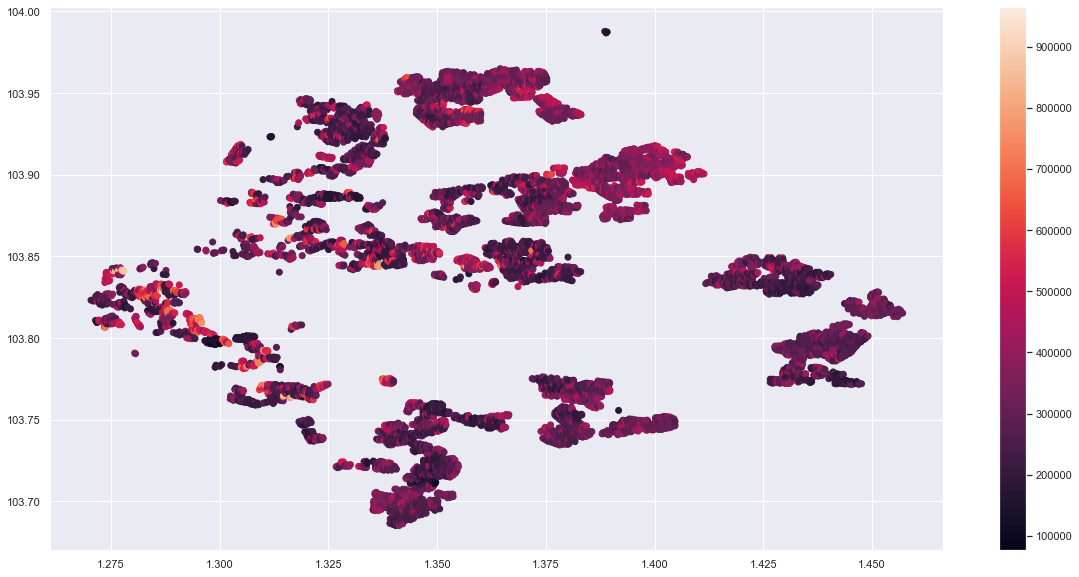

In [15]:
latlongprice = train_df.groupby(['latitude', 'longitude'])['resale_price'].mean().reset_index()
sns.set(rc={'figure.figsize':(20,10)})
plt.scatter(latlongprice['latitude'], latlongprice['longitude'], c=latlongprice['resale_price'])
plt.colorbar()
plt.show()

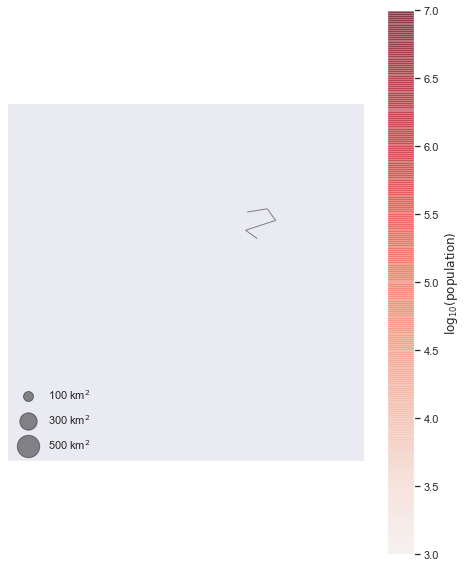

In [28]:
os.environ["PROJ_LIB"] ="C:\\Users\\effbl\\anaconda3\\pkgs\\proj4-5.2.0-h6538335_1006\\Library\\share"
from mpl_toolkits.basemap import Basemap
# 1. Draw the map background
fig = plt.figure(figsize=(8, 10))
m = Basemap(projection='gnom', resolution='h', 
            lat_0=1.290, lon_0=103.852,
            width=1E4, height=1E4)
# m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')


# 2. scatter city data, with color reflecting population
# and size reflecting area
m.scatter(np.array(latlongprice['latitude']), np.array(latlongprice['longitude']), 
          c=np.array(latlongprice['resale_price']), 
          latlon=True, cmap='Reds', alpha=0.5)

# 3. create colorbar and legend
plt.colorbar(label=r'$\log_{10}({\rm population})$')
plt.clim(3, 7)

# make legend with dummy points
for a in [100, 300, 500]:
    plt.scatter([], [], c='k', alpha=0.5, s=a,
                label=str(a) + ' km$^2$')
plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left');
